In [2]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics

# For debug purposes only. To be removed.
import time

In [48]:
# Meixner process parameters. With subordinator.
a = 0.1231
b = -0.5875
d = 3.3588

kappa = 0.5705
eta = 1.5863
lamb = 1.9592
y0 = 1

r = 1.9/100 
q = 1.2/100

S0 = 1124.47

In [49]:
# time_points is the list of points in which we simulate the process at
def BM_path(time_points):
    trajectory = [0]
    for t in range(1, len(time_points)):
        realization = trajectory[-1]+np.sqrt(time_points[t]-time_points[t-1])*np.random.normal()
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [50]:
def poisson_path(intensity, time_points):
    i = intensity*(time_points[1]-time_points[0])
    trajectory = [0]
    for t in time_points:
        trajectory.append(trajectory[-1]+np.random.poisson(i))
    return dict(zip(time_points, trajectory))

In [51]:
# this is defined so that we do not repeatedly compute the integrals inside the meixner trajectory function
def meix_optimization(k, alpha):
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(k,alpha)
    partition = left_part + right_part
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    
    return partition, lambdas, c, gamma_, sigma_

indicator = lambda cond : 1 if cond else 0

In [52]:
partition, lambdas, c, gamma_, sigma_ = meix_optimization(100, 1)

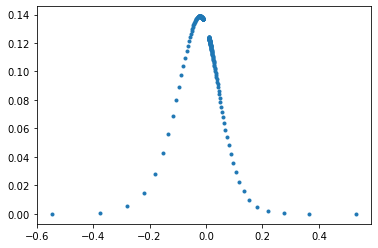

In [53]:
plt.plot(c,lambdas,".")

In [54]:
def meixner_trajectory(time_points):
    # the actual trajectory of the meixner process starts here
    bm = BM_path(time_points)
    N = [poisson_path(l, time_points) for l in lambdas]
    
    trajectory = []
    for t in time_points:
        s = [c[j]*( N[j][t] - lambdas[j]*t*indicator(np.abs(c[j]) < 1) ) for j in range(len(c))]
        #s = [c[j]*( N[j][t] - lambdas[j]*t) for j in range(200)]
        realization = gamma_*t + sigma_*bm[t] + sum(s)
        #realization = sigma_*bm[t] + sum(s)
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [55]:
def cir(T, time_points):
    increment = T/time_points
    y = np.zeros(time_points)
    y[0] = y0
    for i in range(time_points-1):
        y[i+1] = max(y[i] + kappa * (eta - y[i]) * increment + lamb * math.sqrt(y[i])*math.sqrt(increment) * np.random.normal(0,1),0)
    return y

In [56]:
def int_cir(T, time_points):
    Y = np.zeros(time_points+1)
    Y[0] = y0
    fixed_cir = cir(T, time_points)
    for i in range(len(cir(T, time_points))):
        Y[i+1] = Y[i] + fixed_cir[i]
    return dict(zip([T/time_points * i for i in range(time_points+1)], Y/time_points))

In [57]:
def subordinated_meixner(T, time_points):
    path = int_cir(T, time_points)
    det_time = list(path.keys())
    t_points = list(path.values())
    sub_meix = list(meixner_trajectory(t_points).values())
    return dict(zip(det_time, sub_meix))

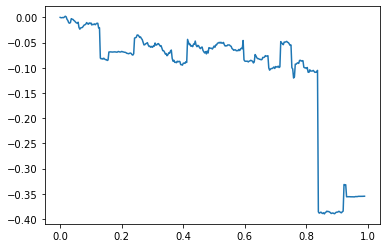

In [58]:
s = subordinated_meixner(1, 360)
plt.plot(list(s.keys()), list(s.values()))

In [139]:
def sub_e(t):
    coth = lambda x : np.cosh(x)/np.sinh(x)
    
    def phi_cir(u):
        gamma = np.sqrt(complex(kappa**2, -2*lamb**2*u))
        return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))
    
    def psi_X(u):
        return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))
    
    def phi(u):
        return np.exp(complex(0, u*((r-q)*t)))*(phi_cir(complex(0,-psi_X(u))))/(phi_cir(complex(0,-psi_X(complex(0,-1)))))**complex(0,u)

    exp_value = phi(complex(0,-1))
    return np.real(exp_value)

In [136]:
sub_e(337/365)

1.0064839440383928

In [107]:
def meixner_sub_martingale(T, time_points):
    path = subordinated_meixner(T, time_points)
    t = np.array(list(path.keys()))
    x_yt = np.array(list(path.values()))
    correction = []
    for i in range(len(x_yt)):
        correction.append(np.exp((r-q)*t[i])/sub_e(t[i]))
    risk_neutral = S0*np.array(correction) * np.exp(x_yt)
    return dict(zip(t, list(risk_neutral)))

0.9999752932854494


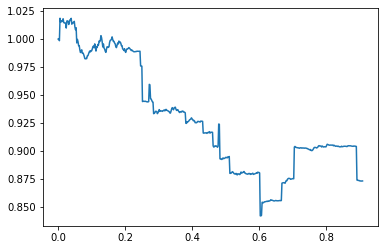

In [108]:
sub_path = meixner_sub_martingale(338/365, 500) 
print(list(sub_path.values())[0])
plt.plot(list(sub_path.keys()), list(sub_path.values()))

# Monte Carlo simulations with Subordinator

In [109]:
def payoff_eur_call(ST, K):
    return max(ST-K,0)

In [110]:
def mc_ec_sub_meixner(T, K, sims):
    t=[]
    for i in range(sims):
        final_value = list(meixner_sub_martingale(T,200).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [111]:
%%time
resl = mc_ec_sub_meixner(338/365, 1150, 1000)

CPU times: user 2min 57s, sys: 593 ms, total: 2min 58s
Wall time: 3min


In [100]:
resl

16.395856180949146

In [140]:
path = subordinated_meixner(338/365, 300)
t = np.array(list(path.keys()))
x_yt = np.array(list(path.values()))
correction = []
for cir_times in t:
    correction.append(np.exp((r-q)*cir_times)/sub_e(cir_times))
S0 * np.array(correction) * np.exp(x_yt)

<ipython-input-139-109dc18e7990>:2: RuntimeWarning: divide by zero encountered in cdouble_scalars
  coth = lambda x : np.cosh(x)/np.sinh(x)
<ipython-input-139-109dc18e7990>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  coth = lambda x : np.cosh(x)/np.sinh(x)
<ipython-input-139-109dc18e7990>:6: RuntimeWarning: invalid value encountered in cdouble_scalars
  return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))


array([          nan, 1131.73671683, 1132.22260652, 1133.22609987,
       1135.41765053, 1134.24881198, 1134.0697099 , 1134.68671894,
       1140.72968057, 1148.28596292, 1147.51668701, 1146.81421805,
       1148.4859389 , 1149.51940979, 1147.26509714, 1140.43169562,
       1143.53035411,  950.67238203,  947.24483522,  959.06645693,
        967.38759655,  967.88364676,  969.89846196,  970.47110549,
        969.7598901 ,  970.82327139,  975.50242725,  982.04464786,
        974.0333036 ,  978.1446403 ,  981.30837682,  982.68015656,
        980.33183197,  977.70152828,  976.11179734,  976.34718249,
        970.29320832,  972.96939686,  969.27890946, 1029.62947945,
       1025.91849984, 1027.77774319, 1016.42765915, 1014.99845289,
       1012.35673347, 1014.24317538, 1015.55271519, 1011.8367054 ,
       1009.39686002, 1006.74167562, 1005.50009282, 1007.4205544 ,
       1011.78799803, 1015.65600517, 1015.5388532 , 1015.27760208,
       1017.77730863, 1019.30106381, 1021.97079288, 1022.62696

In [141]:
correction

[nan,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0